### Project members : 
 EL-AJJOURI Safaa
 
 BOUTAHAR Mohammed

# Sentiment Analysis

## All what you need to install

In [ ]:
!pip install -U imbalanced-learn
!pip install spacy
!python -m spacy download en_core_web_sm

## All what you need to import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import string
import nltk 
import string
from nltk.corpus import stopwords
import spacy
from tqdm.auto import tqdm
import time

## Import the dataset

In [2]:
data = pd.read_csv("reviews_rating1,3,5.csv", sep=';', on_bad_lines="skip", encoding='ISO-8859-1')

In [68]:
data.head(10)

,Review,Rating
0,Hollywood Hotel sure lives up to its name. Yo...,5
1,We had a reservation at this hotel this weeken...,5
2,Pil give us great customer service. He took go...,5
3,Very friendly staff. Daniel did an excellent j...,5
4,Daniel made me feel very comfortable and welco...,5
5,"We needed bag storage, early check in, and bag...",5
6,We have stayed at this hotel three times now a...,5
7,The Hollywood Hotel is the place to stay when ...,5
8,I love Pil heâs the best so sweet and always...,5
9,Pil was the best manager ive had the pleasure ...,5


In [61]:
data.tail()

,Review,Rating
38787,ok price look hotel ok little run average clea...,2
38788,deceptive staff deceptive desk staff claiming ...,2
38789,not impressed unfriendly staff checked asked h...,2
38790,"ok just looks nice modern outside, desk staff ...",2
38791,"people talking, ca n't believe excellent ratin...",2


## Evaluating the dataset

### Handling Null Values

In [3]:
data.isna().any()

Review    False
Rating    False
dtype: bool

In [4]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

### Useful information

In [5]:
data.shape

(15706, 2)

5    6100
3    5243
1    4363
Name: Rating, dtype: int64


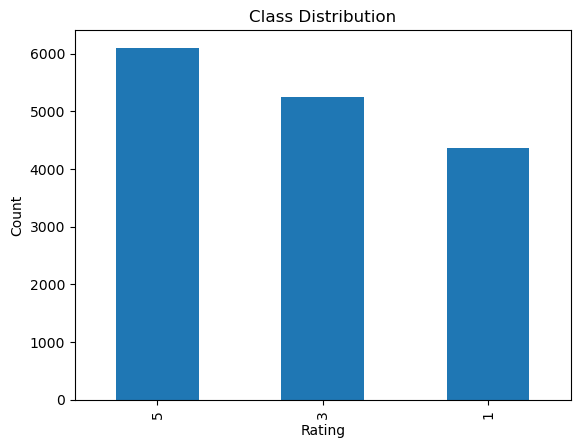

In [6]:
# Count the number of instances in each class
class_counts = data['Rating'].value_counts()
print(class_counts)
class_counts.plot.bar()
plt.title('Class Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21500 entries, 0 to 21499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  21500 non-null  object
 1   Rating  21500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 336.1+ KB


### In case you want to sub divide the dataset into sub-sets of equal shapes

In [10]:
for rating in range(1, 6):
    # Filter the DataFrame to get only the reviews with the current rating
    rating_df = data[data['Rating'] == rating]
    
    # Sample 4300 reviews from the filtered DataFrame and add them to the sampled DataFrame
    sub_data = pd.DataFrame(rating_df.sample(n=4300, random_state=42))

    # Write the DataFrame to a CSV file
    sub_data.to_csv(f'sub_data_{rating}.csv', sep=';', index=False)
print("Success")

Success


## Preprocessing the Text

In [7]:
# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Define stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [8]:
nlp

### Lemmatization

In [13]:
def preprocess_text(text):
    # Parse the text with Spacy
    doc = nlp(text)
    
    # Lemmatize the tokens and remove stop words
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop]
    
    # Join the lemmas back into a string and return it
    return " ".join(lemmas)

In [14]:
%%time

tqdm.pandas()

data['Review'] = data['Review'].progress_apply(preprocess_text)

  0%|          | 0/15706 [00:00<?, ?it/s]

Wall time: 2min 55s


### Remove unwanted information

In [9]:
def remove_URL (text):
    url = re.compile(r"https?://\s+ www\.\s+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)
         

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F" # emoticons
        u"\U0001F300-\U0001F5FF" # symbols & pictographs
        u"\U0001F680-\U0001F6FF" # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" # flags (i0s)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)


def remove_punct (text):
    table = str.maketrans ("","",string.punctuation)
    return text.translate(table)

stop = set (stopwords.words ( "english"))
def remove_stopwords (text):
    text = [word.lower () for word in text.split() if word.lower() not in stop]
    return " ".join (text)

In [10]:
def cleanDataframe(df):
    Review_cleaned = df.Review.map(lambda x: remove_URL(x))
    Review_cleaned = Review_cleaned.map(lambda x: remove_html(x))
    Review_cleaned = Review_cleaned.map(lambda x: remove_emoji(x))
    Review_cleaned = Review_cleaned.map(lambda x: remove_punct(x)) 
    Review_cleaned = Review_cleaned.map(remove_stopwords)   
    return Review_cleaned

In [71]:
#comparison of cleaned data and raw data
df=[]
df = data.copy()
df.insert(1, "Review_cleaned", cleanDataframe(data))
df

,Review,Review_cleaned,Rating
0,Hollywood Hotel sure lives up to its name. Yo...,hollywood hotel sure lives name really get sen...,5
1,We had a reservation at this hotel this weeken...,reservation hotel weekend chose book directly ...,5
2,Pil give us great customer service. He took go...,pil give us great customer service took good c...,5
3,Very friendly staff. Daniel did an excellent j...,friendly staff daniel excellent job customer s...,5
4,Daniel made me feel very comfortable and welco...,daniel made feel comfortable welcome check mad...,5
...,...,...,...
15701,worst sleep hip tooooo hip nite club building ...,worst sleep hip tooooo hip nite club building ...,1
15702,"june 08 stay stayed hotel june 6/6-6/8/08, rea...",june 08 stay stayed hotel june 666808 read rev...,1
15703,not stay hotel brought group february worst ho...,stay hotel brought group february worst hotel ...,1
15704,returning la concha nightmare surprising hotel...,returning la concha nightmare surprising hotel...,1


In [11]:
#data cleaning
data.Review = cleanDataframe(data)
data

,Review,Rating
0,hollywood hotel sure lives name really get sen...,5
1,reservation hotel weekend chose book directly ...,5
2,pil give us great customer service took good c...,5
3,friendly staff daniel excellent job customer s...,5
4,daniel made feel comfortable welcome check mad...,5
...,...,...
15701,worst sleep hip tooooo hip nite club building ...,1
15702,june 08 stay stayed hotel june 666808 read rev...,1
15703,stay hotel brought group february worst hotel ...,1
15704,returning la concha nightmare surprising hotel...,1


## Commonly Used Words

In [12]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(data['Review'].values)

In [13]:
# Split the text into individual words
words = all_text.split()

In [14]:
# Count the frequency of each word
word_counts = Counter(words)

In [15]:
top_words = word_counts.most_common(20)
top_words

[('hotel', 20465),
 ('room', 18894),
 ('staff', 7500),
 ('stay', 7106),
 ('great', 6492),
 ('rooms', 5954),
 ('good', 4975),
 ('location', 4884),
 ('clean', 4503),
 ('service', 4218),
 ('stayed', 4153),
 ('nice', 4067),
 ('night', 4048),
 ('would', 3991),
 ('us', 3859),
 ('one', 3651),
 ('time', 3518),
 ('desk', 3420),
 ('universal', 3306),
 ('like', 3144)]

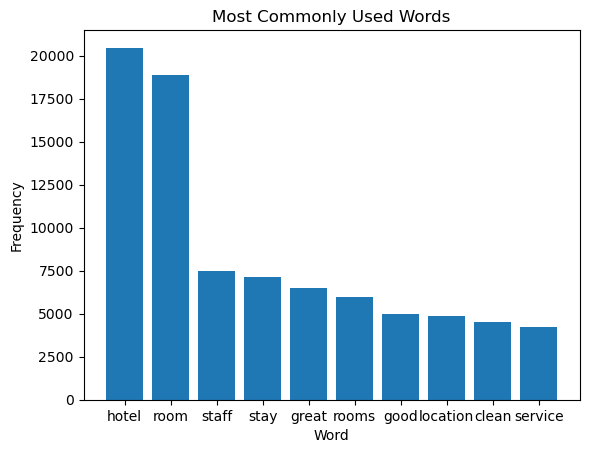

In [16]:
# Create a bar chart of the most common words
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

### Note:
It wasn't really important to remove some frequently used words like 'room' and 'hotel' since models already handel that situation by ignoring words that are used in all classes

## Converting Text into Numerical Features / Vectorization

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Review'])
y = data['Rating']

# Machine Learning Models

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold

#Hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

In [19]:
def cross_validation(model, X, y, folds):
    # Define your cross-validation strategy
    cv = KFold(n_splits=folds, shuffle=True, random_state=42)
    
    accuracies = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    accuracies = pd.Series(accuracies)
    print("Accuracy : min=", accuracies.min()*100, "%  max=", accuracies.max()*100, "%  mean=", accuracies.mean()*100, "%")

    precisions = cross_val_score(model, X, y, cv=cv, scoring='precision_macro')
    print("Precisions : min=", precisions.min()*100, "%  max=",precisions.max()*100, "%  mean=", precisions.mean()*100, "%")
    
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
    print("F1_score : min=", f1_scores.min()*100, "%  max=",f1_scores.max()*100, "%  mean=",f1_scores.mean()*100, "%")
    
    y_pred = cross_val_predict(model, X, y, cv=cv)

    cm = confusion_matrix(y, y_pred)

    cm_display = ConfusionMatrixDisplay(cm).plot()


## Support Vector Machines

In [20]:
from sklearn import svm

# train an SVM model
svmModel = svm.SVC(kernel='linear')

svmModel

SVC(kernel='linear')

### Cross-Validation approach

Accuracy : min= 85.86437440305636 %  max= 86.9191597708466 %  mean= 86.42553841707922 %
Precisions : min= 85.46116142873208 %  max= 86.4690334589112 %  mean= 85.9996075336267 %
F1_score : min= 85.38767239998982 %  max= 86.50583542985747 %  mean= 85.96254113286577 %


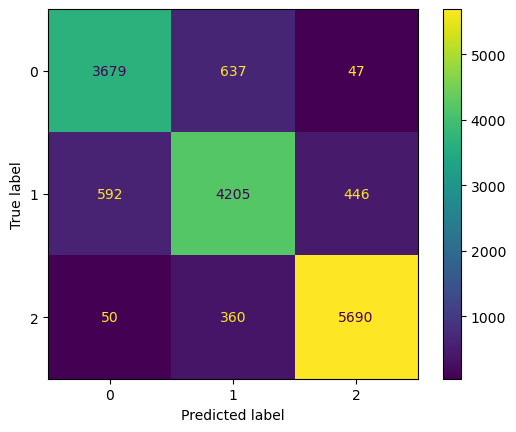

In [15]:
cross_validation(svmModel, X, y, 5)

### Hold-Out approach 

In [12]:
%%time
#training
svmModel.fit(X_train, y_train)

Wall time: 27.3 s


SVC(kernel='linear')

In [13]:
#testing
y_pred = svmModel.predict(X_test)

array([3, 3, 5, ..., 3, 5, 3], dtype=int64)

Accuracy: 86.9191597708466 %
precision score: 86.4690334589112 %
f1score: 86.50583542985747 %


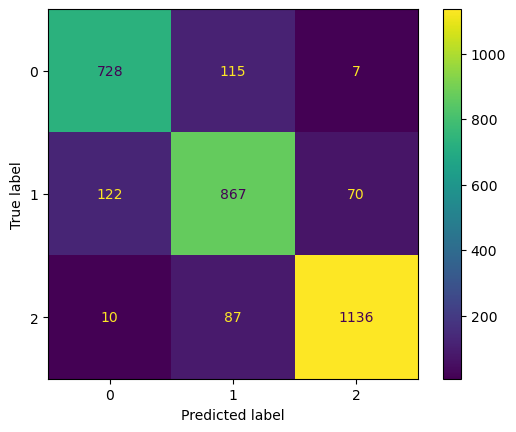

In [14]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("precision score:", precision*100, "%")
print("f1score:", f1*100, "%")

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

## Multinomial Naive Bayes Model

In [23]:
from sklearn.naive_bayes import MultinomialNB
# train a Naive Bayes classifier
mnb = MultinomialNB()
mnb

MultinomialNB()

### Hold-out approach

In [24]:
#training
mnb.fit(X_train, y_train)

MultinomialNB()

In [25]:
#testing
y_pred = mnb.predict(X_test)

Accuracy: 83.95926161680458 %
precision score: 84.95793466497888 %
f1score: 82.97369343195132 %


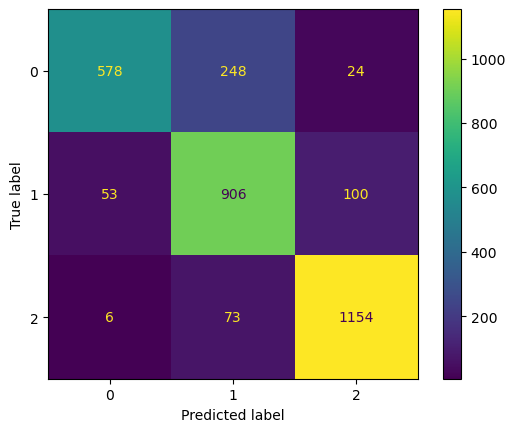

In [26]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("precision score:", precision*100, "%")
print("f1score:", f1*100, "%")

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

### Cross-Validation approach

Accuracy : min= 75.15923566878982 %  max= 89.80891719745223 %  mean= 83.82109167136983 %
Precisions : min= 79.216213792485 %  max= 90.44031243519734 %  mean= 84.92387505905025 %
F1_score : min= 74.35978835978835 %  max= 88.94236315988991 %  mean= 82.83926340083816 %


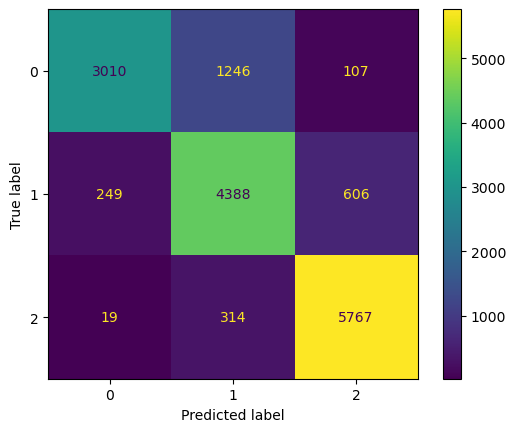

In [27]:
cross_validation(mnb, X, y, 100)

## Decision Tree

In [21]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc

DecisionTreeClassifier()

### Hold-out approach

In [23]:
%%time
#training
dtc.fit(X_train, y_train)

Wall time: 3.8 s


DecisionTreeClassifier()

In [24]:
#testing
y_pred = dtc.predict(X_test)

Accuracy: 70.21005728835136 %
precision score: 70.07897047261244 %
f1 score: 69.80197734709387 %


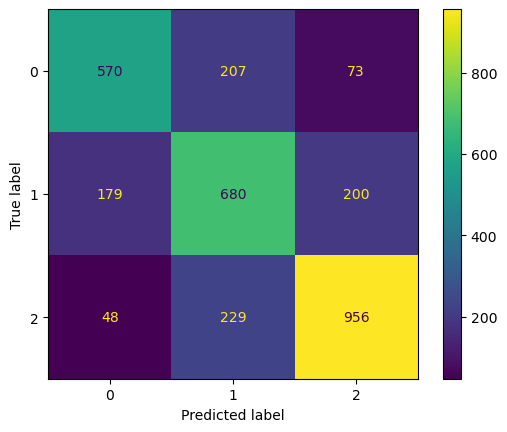

In [27]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("precision score:", precision*100, "%")
print("f1 score:", f1*100, "%")
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

### Cross-Validation approach

Accuracy : min= 67.60025461489498 %  max= 72.48407643312102 %  mean= 70.46356128394021 %
Precisions : min= 67.15216130808061 %  max= 72.20516407371643 %  mean= 69.9180804083425 %
F1_score : min= 66.62877396581266 %  max= 71.11284081661532 %  mean= 69.30360978828179 %


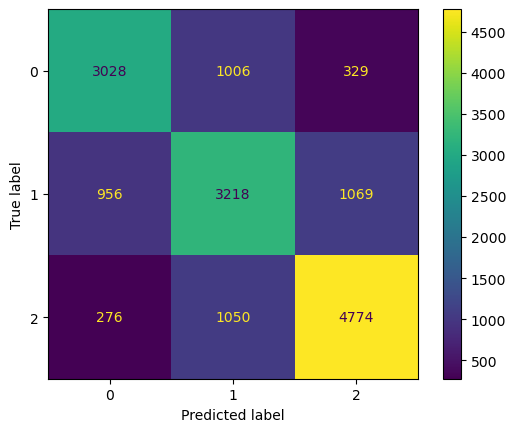

In [22]:
cross_validation(dtc, X, y, 10)

## Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
rfc

RandomForestClassifier(random_state=0)

### Hold-out approach

In [32]:
%%time
#training
rfc.fit(X_train, y_train)

Wall time: 19.4 s


RandomForestClassifier(random_state=0)

In [33]:
#testing
y_pred = rfc.predict(X_test)

Accuracy: 82.78166772756205 %
precision score: 82.38152556232077 %
f1 score: 82.09793271226515 %


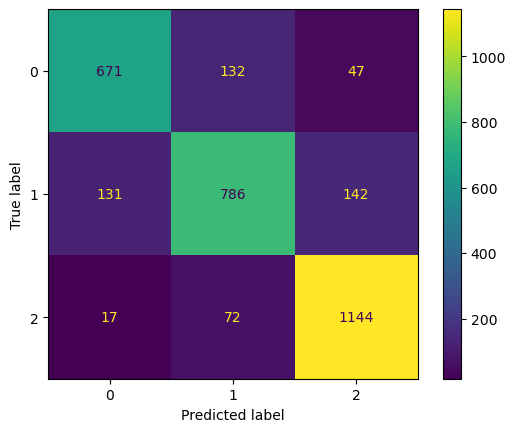

In [35]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Accuracy:", acc*100, "%")
print("precision score:", precision*100, "%")
print("f1 score:", f1*100, "%")
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

### Cross-Validation approach

Accuracy : min= 81.75740210124164 %  max= 83.25907065563335 %  mean= 82.47161674176023 %
Precisions : min= 81.98395844904768 %  max= 83.01326585883872 %  mean= 82.39314264819596 %
F1_score : min= 81.26932776545104 %  max= 82.6359738282859 %  mean= 81.89376814702578 %


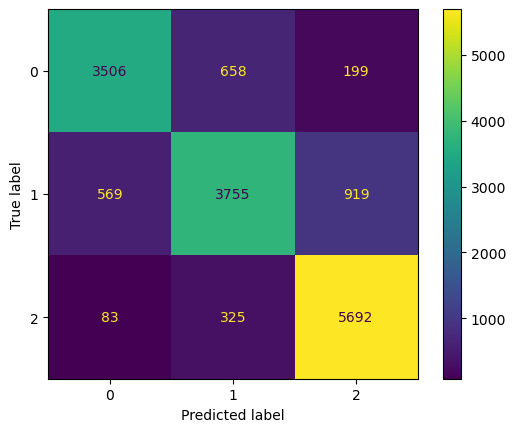

In [36]:
cross_validation(rfc, X, y, 5)

# The End